In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FARS Analysis") \
    .getOrCreate()

### **Uploading the dataset**

In [ ]:
df = spark.read.csv('fars.csv', header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- OBJECTID: integer (nullable = true)
 |-- STATE: integer (nullable = true)
 |-- STATENAME: string (nullable = true)
 |-- ST_CASE: integer (nullable = true)
 |-- PEDS: integer (nullable = true)
 |-- PERNOTMVIT: integer (nullable = true)
 |-- VE_TOTAL: integer (nullable = true)
 |-- VE_FORMS: integer (nullable = true)
 |-- PVH_INVL: integer (nullable = true)
 |-- PERSONS: integer (nullable = true)
 |-- PERMVIT: integer (nullable = true)
 |-- COUNTY: integer (nullable = true)
 |-- COUNTYNAME: string (nullable = true)
 |-- CITY: integer (nullable = true)
 |-- CITYNAME: string (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- MONTHNAME: string (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAYNAME: integer (nullable = true)
 |-- DAY_WEEK: integer (nullable = true)
 |-- DAY_WEEKNAME: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- HOURNAME: string (nullable = true)
 |-- MINUTE: integer (nullable = true)
 

In [ ]:
# List of columns to keep
columns_to_keep = [
    # Accident Severity Analysis
    "FATALS", "VE_TOTAL", "PERSONS", "PEDS",
    "HARM_EV", "HARM_EVNAME", "MAN_COLL", "MAN_COLLNAME",
    "WEATHER", "WEATHERNAME", "LGT_COND", "LGT_CONDNAME",

    # Temporal Trends
    "YEAR", "MONTH", "MONTHNAME", "DAY", "DAYNAME",
    "DAY_WEEK", "HOUR", "MINUTE",

    # Road and Environmental Factors
    "FUNC_SYS", "FUNC_SYSNAME", "REL_ROAD", "REL_ROADNAME",
    "TYP_INT", "TYP_INTNAME", "WRK_ZONE", "WRK_ZONENAME"
]

In [ ]:
use_df = df.select(columns_to_keep)

In [ ]:
# Show the schema of the filtered DataFrame
use_df.printSchema()

root
 |-- FATALS: integer (nullable = true)
 |-- VE_TOTAL: integer (nullable = true)
 |-- PERSONS: integer (nullable = true)
 |-- PEDS: integer (nullable = true)
 |-- HARM_EV: integer (nullable = true)
 |-- HARM_EVNAME: string (nullable = true)
 |-- MAN_COLL: integer (nullable = true)
 |-- MAN_COLLNAME: string (nullable = true)
 |-- WEATHER: integer (nullable = true)
 |-- WEATHERNAME: string (nullable = true)
 |-- LGT_COND: integer (nullable = true)
 |-- LGT_CONDNAME: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- MONTHNAME: string (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAYNAME: integer (nullable = true)
 |-- DAY_WEEK: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- MINUTE: integer (nullable = true)
 |-- FUNC_SYS: integer (nullable = true)
 |-- FUNC_SYSNAME: string (nullable = true)
 |-- REL_ROAD: integer (nullable = true)
 |-- REL_ROADNAME: string (nullable = true)
 |-- TYP_INT: integer (

In [ ]:
# Display the first few rows of the filtered DataFrame
use_df.show(5)

+------+--------+-------+----+-------+--------------------+--------+--------------------+-------+-----------+--------+------------------+----+-----+---------+---+-------+--------+----+------+--------+--------------------+--------+------------+-------+-------------------+--------+------------+
|FATALS|VE_TOTAL|PERSONS|PEDS|HARM_EV|         HARM_EVNAME|MAN_COLL|        MAN_COLLNAME|WEATHER|WEATHERNAME|LGT_COND|      LGT_CONDNAME|YEAR|MONTH|MONTHNAME|DAY|DAYNAME|DAY_WEEK|HOUR|MINUTE|FUNC_SYS|        FUNC_SYSNAME|REL_ROAD|REL_ROADNAME|TYP_INT|        TYP_INTNAME|WRK_ZONE|WRK_ZONENAME|
+------+--------+-------+----+-------+--------------------+--------+--------------------+-------+-----------+--------+------------------+----+-----+---------+---+-------+--------+----+------+--------+--------------------+--------+------------+-------+-------------------+--------+------------+
|     1|       2|      3|   0|     12|Motor Vehicle In-...|       7|Sideswipe - Same ...|      1|      Clear|       1|

In [ ]:
# Dropping YEAR column as the data set has value 2022 for all the rows and hence it does not provide any meaningful information for our analysis
use_df = use_df.drop("YEAR")

# Verify the updated schema
use_df.printSchema()

# Show the first few rows to confirm
use_df.show(5)


root
 |-- FATALS: integer (nullable = true)
 |-- VE_TOTAL: integer (nullable = true)
 |-- PERSONS: integer (nullable = true)
 |-- PEDS: integer (nullable = true)
 |-- HARM_EV: integer (nullable = true)
 |-- HARM_EVNAME: string (nullable = true)
 |-- MAN_COLL: integer (nullable = true)
 |-- MAN_COLLNAME: string (nullable = true)
 |-- WEATHER: integer (nullable = true)
 |-- WEATHERNAME: string (nullable = true)
 |-- LGT_COND: integer (nullable = true)
 |-- LGT_CONDNAME: string (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- MONTHNAME: string (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAYNAME: integer (nullable = true)
 |-- DAY_WEEK: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- MINUTE: integer (nullable = true)
 |-- FUNC_SYS: integer (nullable = true)
 |-- FUNC_SYSNAME: string (nullable = true)
 |-- REL_ROAD: integer (nullable = true)
 |-- REL_ROADNAME: string (nullable = true)
 |-- TYP_INT: integer (nullable = true)
 |-- TYP_INTNAME: st

##### **Handling Missing Values**

In [ ]:
from pyspark.sql.functions import col, sum

# Check for missing values in each column
missing_values = use_df.select(
    [(sum(col(c).isNull().cast("int")).alias(c)) for c in use_df.columns]
)

# Show the count of missing values per column
missing_values.show()

+------+--------+-------+----+-------+-----------+--------+------------+-------+-----------+--------+------------+-----+---------+---+-------+--------+----+------+--------+------------+--------+------------+-------+-----------+--------+------------+
|FATALS|VE_TOTAL|PERSONS|PEDS|HARM_EV|HARM_EVNAME|MAN_COLL|MAN_COLLNAME|WEATHER|WEATHERNAME|LGT_COND|LGT_CONDNAME|MONTH|MONTHNAME|DAY|DAYNAME|DAY_WEEK|HOUR|MINUTE|FUNC_SYS|FUNC_SYSNAME|REL_ROAD|REL_ROADNAME|TYP_INT|TYP_INTNAME|WRK_ZONE|WRK_ZONENAME|
+------+--------+-------+----+-------+-----------+--------+------------+-------+-----------+--------+------------+-----+---------+---+-------+--------+----+------+--------+------------+--------+------------+-------+-----------+--------+------------+
|     0|       0|      0|   0|      0|          0|       0|           0|      0|          0|       0|           0|    0|        0|  0|      0|       0|   0|     0|       0|           0|       0|           0|      0|          0|       0|           0|


##### **Data Transformations**

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Step 1: Encode Categorical Columns using StringIndexer and OneHotEncoder
# List of categorical columns to encode
categorical_columns = ["HARM_EVNAME", "MAN_COLLNAME", "WEATHERNAME", "LGT_CONDNAME",
                       "FUNC_SYSNAME", "REL_ROADNAME", "TYP_INTNAME", "WRK_ZONENAME"]

# Placeholder for the encoded DataFrame
encoded_df = use_df

# Apply StringIndexer and OneHotEncoder
for column in categorical_columns:
    # Step 1a: String Indexing
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index")
    encoded_df = indexer.fit(encoded_df).transform(encoded_df)

    # Step 1b: One-Hot Encoding
    encoder = OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_onehot")
    encoded_df = encoder.fit(encoded_df).transform(encoded_df)

# Show the resulting DataFrame with one-hot encoded columns
encoded_df.select("HARM_EVNAME", "HARM_EVNAME_index", "HARM_EVNAME_onehot").show(5)

+--------------------+-----------------+------------------+
|         HARM_EVNAME|HARM_EVNAME_index|HARM_EVNAME_onehot|
+--------------------+-----------------+------------------+
|Motor Vehicle In-...|              0.0|    (54,[0],[1.0])|
|Motor Vehicle In-...|              0.0|    (54,[0],[1.0])|
|Tree (Standing Only)|              3.0|    (54,[3],[1.0])|
|               Ditch|              6.0|    (54,[6],[1.0])|
|          Pedestrian|              1.0|    (54,[1],[1.0])|
+--------------------+-----------------+------------------+
only showing top 5 rows



In [ ]:
encoded_df.show(10)

+------+--------+-------+----+-------+--------------------+--------+--------------------+-------+-----------+--------+------------------+-----+---------+---+-------+--------+----+------+--------+--------------------+--------+------------+-------+--------------------+--------+------------+-----------------+------------------+------------------+-------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+------------------+-------------------+-----------------+------------------+------------------+-------------------+
|FATALS|VE_TOTAL|PERSONS|PEDS|HARM_EV|         HARM_EVNAME|MAN_COLL|        MAN_COLLNAME|WEATHER|WEATHERNAME|LGT_COND|      LGT_CONDNAME|MONTH|MONTHNAME|DAY|DAYNAME|DAY_WEEK|HOUR|MINUTE|FUNC_SYS|        FUNC_SYSNAME|REL_ROAD|REL_ROADNAME|TYP_INT|         TYP_INTNAME|WRK_ZONE|WRK_ZONENAME|HARM_EVNAME_index|HARM_EVNAME_onehot|MAN_COLLNAME_index|MAN_COLLNAME_onehot|WEATHERNAME_index|WEATHERNAME_onehot|LG

In [ ]:
encoded_df.printSchema()

root
 |-- FATALS: integer (nullable = true)
 |-- VE_TOTAL: integer (nullable = true)
 |-- PERSONS: integer (nullable = true)
 |-- PEDS: integer (nullable = true)
 |-- HARM_EV: integer (nullable = true)
 |-- HARM_EVNAME: string (nullable = true)
 |-- MAN_COLL: integer (nullable = true)
 |-- MAN_COLLNAME: string (nullable = true)
 |-- WEATHER: integer (nullable = true)
 |-- WEATHERNAME: string (nullable = true)
 |-- LGT_COND: integer (nullable = true)
 |-- LGT_CONDNAME: string (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- MONTHNAME: string (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAYNAME: integer (nullable = true)
 |-- DAY_WEEK: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- MINUTE: integer (nullable = true)
 |-- FUNC_SYS: integer (nullable = true)
 |-- FUNC_SYSNAME: string (nullable = true)
 |-- REL_ROAD: integer (nullable = true)
 |-- REL_ROADNAME: string (nullable = true)
 |-- TYP_INT: integer (nullable = true)
 |-- TYP_INTNAME: st

In [ ]:
# List of columns to keep
final_columns = [
    # Numeric columns
    "FATALS", "VE_TOTAL", "PERSONS", "PEDS",

    # One-hot encoded columns
    "HARM_EVNAME_onehot", "MAN_COLLNAME_onehot", "WEATHERNAME_onehot",
    "LGT_CONDNAME_onehot", "FUNC_SYSNAME_onehot", "REL_ROADNAME_onehot",
    "TYP_INTNAME_onehot", "WRK_ZONENAME_onehot",

    # Optional: Add any additional columns you need for reference or EDA
    "MONTH", "DAY", "HOUR", "MINUTE"
]

# Filter the DataFrame to include only the specified columns
df = encoded_df.select(final_columns)

# Show the schema and first few rows of the filtered DataFrame
df.printSchema()
df.show(5)


root
 |-- FATALS: integer (nullable = true)
 |-- VE_TOTAL: integer (nullable = true)
 |-- PERSONS: integer (nullable = true)
 |-- PEDS: integer (nullable = true)
 |-- HARM_EVNAME_onehot: vector (nullable = true)
 |-- MAN_COLLNAME_onehot: vector (nullable = true)
 |-- WEATHERNAME_onehot: vector (nullable = true)
 |-- LGT_CONDNAME_onehot: vector (nullable = true)
 |-- FUNC_SYSNAME_onehot: vector (nullable = true)
 |-- REL_ROADNAME_onehot: vector (nullable = true)
 |-- TYP_INTNAME_onehot: vector (nullable = true)
 |-- WRK_ZONENAME_onehot: vector (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- MINUTE: integer (nullable = true)

+------+--------+-------+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+-----+---+----+------+
|FATALS|VE_TOTAL|PERSONS|PEDS|HARM_EVNAME_onehot|MAN_COLLNAME_onehot|WEA

In [ ]:
from pyspark.ml.feature import VectorAssembler

# List of all feature columns (numeric + one-hot encoded + time features)
feature_columns = [
    "VE_TOTAL", "PERSONS", "PEDS",  # Numeric features
    "HARM_EVNAME_onehot", "MAN_COLLNAME_onehot", "WEATHERNAME_onehot",  # One-hot encoded
    "LGT_CONDNAME_onehot", "FUNC_SYSNAME_onehot", "REL_ROADNAME_onehot",
    "TYP_INTNAME_onehot", "WRK_ZONENAME_onehot",  # One-hot encoded
    "MONTH", "DAY", "HOUR", "MINUTE"  # Time features
]

# Assemble all features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_with_features = assembler.transform(df)

# Show the transformed DataFrame
df_with_features.select("features", "FATALS").show(5)

+--------------------+------+
|            features|FATALS|
+--------------------+------+
|(125,[0,1,3,61,66...|     1|
|(125,[0,1,3,59,66...|     2|
|(125,[0,1,6,57,67...|     1|
|(125,[0,1,9,57,67...|     1|
|(125,[0,1,2,4,57,...|     1|
+--------------------+------+
only showing top 5 rows



### Exploratory Data Analysis:

##### **Numerical Variables**

In [ ]:
# Descriptive statistics for all numeric variables
numeric_columns = ["FATALS", "VE_TOTAL", "PERSONS", "PEDS", "MONTH", "DAY", "HOUR", "MINUTE"]
df_with_features.select(numeric_columns).describe().show()

+-------+------------------+------------------+------------------+-------------------+-----------------+-----------------+------------------+-----------------+
|summary|            FATALS|          VE_TOTAL|           PERSONS|               PEDS|            MONTH|              DAY|              HOUR|           MINUTE|
+-------+------------------+------------------+------------------+-------------------+-----------------+-----------------+------------------+-----------------+
|  count|             39480|             39480|             39480|              39480|            39480|            39480|             39480|            39480|
|   mean|1.0837132725430598| 1.582066869300912|2.1958966565349542|0.24389564336372846|6.695896656534955|15.69708713272543| 13.47966058763931|29.28465045592705|
| stddev|0.3472444798679061|0.8459453769160157| 1.778047042245726| 0.6169857916600503|3.373222500473402|8.826212984044385|10.304645096577786| 18.3836858442451|
|    min|                 1|            

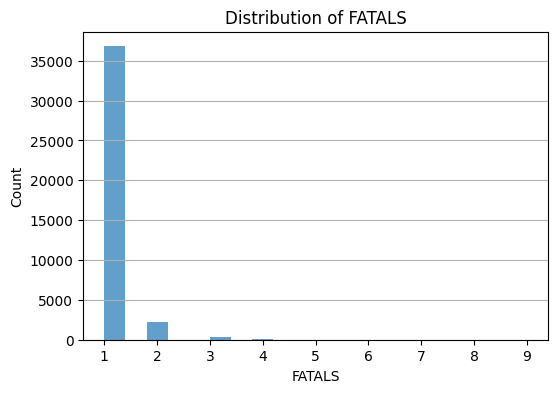

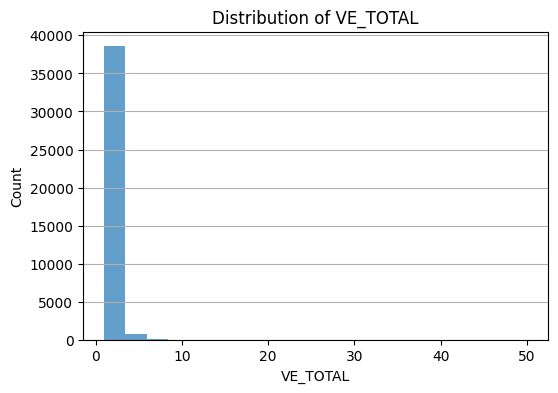

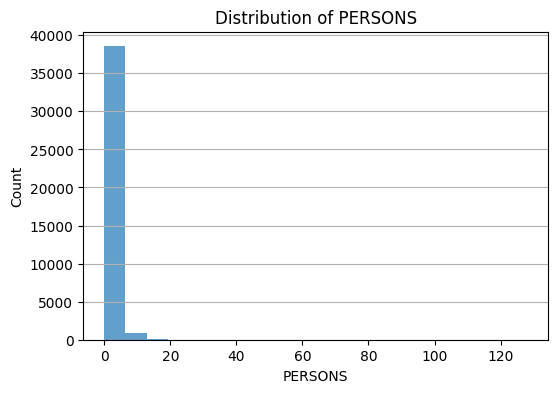

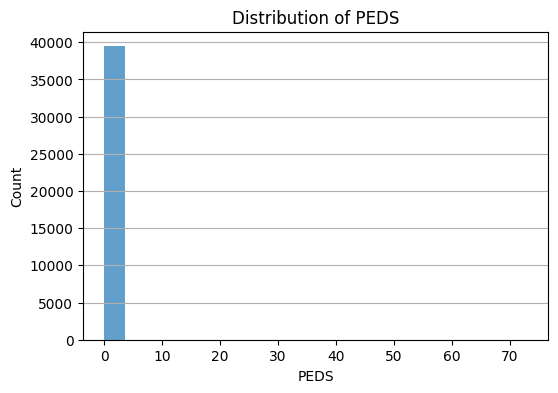

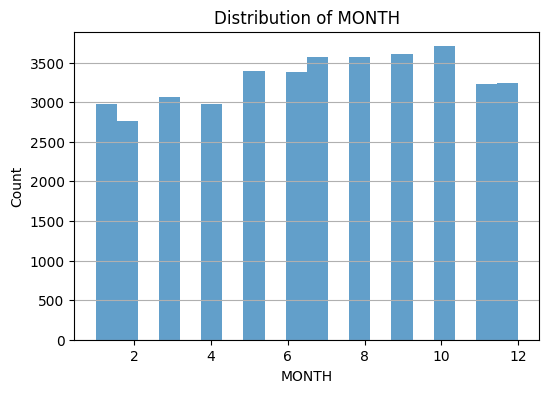

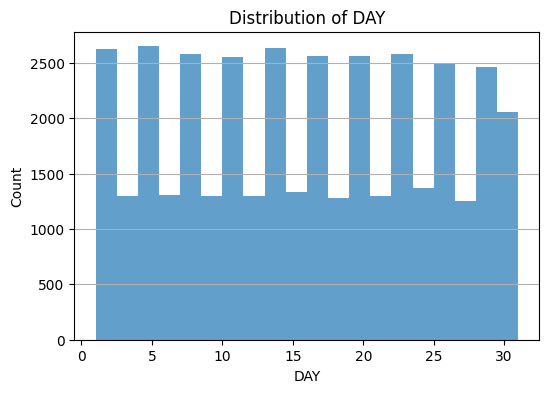

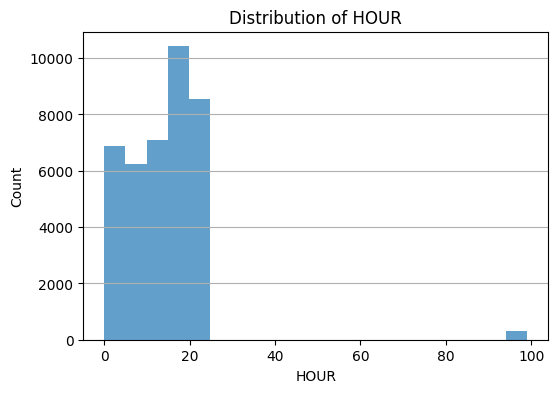

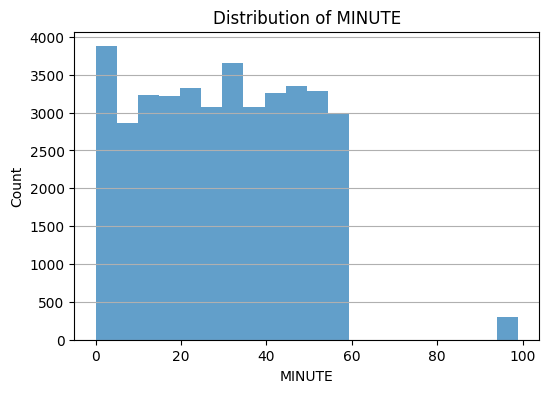

In [ ]:
# Visualize distributions of numeric variables
import matplotlib.pyplot as plt

numeric_data = df_with_features.select(numeric_columns).toPandas()
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    plt.hist(numeric_data[col], bins=20, alpha=0.7)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(axis="y")
    plt.show()

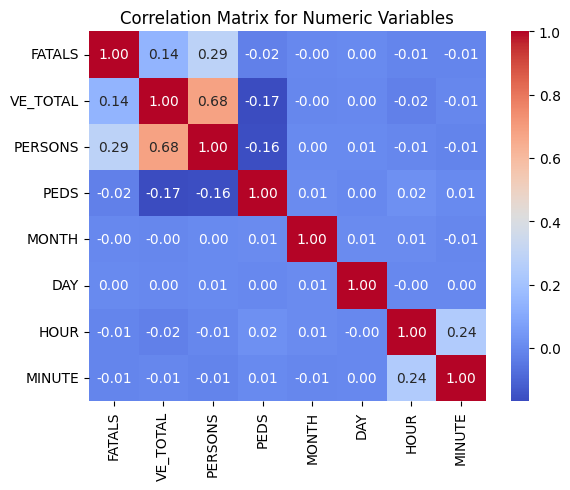

In [ ]:
# Compute correlation matrix for numeric variables
import seaborn as sns

correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Numeric Variables")
plt.show()

##### **Categorical Variables**

In [ ]:
# Count unique values in categorical columns (one-hot encoded features)
categorical_columns = [
    "HARM_EVNAME_onehot", "MAN_COLLNAME_onehot", "WEATHERNAME_onehot",
    "LGT_CONDNAME_onehot", "FUNC_SYSNAME_onehot", "REL_ROADNAME_onehot",
    "TYP_INTNAME_onehot", "WRK_ZONENAME_onehot"
]

# Check the distribution of each categorical variable
for col in categorical_columns:
    df_with_features.groupBy(col).count().show(truncate=False)

+------------------+-----+
|HARM_EVNAME_onehot|count|
+------------------+-----+
|(54,[32],[1.0])   |72   |
|(54,[9],[1.0])    |776  |
|(54,[19],[1.0])   |228  |
|(54,[50],[1.0])   |6    |
|(54,[39],[1.0])   |33   |
|(54,[30],[1.0])   |76   |
|(54,[13],[1.0])   |448  |
|(54,[43],[1.0])   |18   |
|(54,[16],[1.0])   |292  |
|(54,[10],[1.0])   |531  |
|(54,[44],[1.0])   |16   |
|(54,[7],[1.0])    |897  |
|(54,[15],[1.0])   |304  |
|(54,[14],[1.0])   |415  |
|(54,[42],[1.0])   |20   |
|(54,[24],[1.0])   |120  |
|(54,[52],[1.0])   |3    |
|(54,[4],[1.0])    |1307 |
|(54,[37],[1.0])   |35   |
|(54,[11],[1.0])   |500  |
+------------------+-----+
only showing top 20 rows

+-------------------+-----+
|MAN_COLLNAME_onehot|count|
+-------------------+-----+
|(9,[8],[1.0])      |43   |
|(9,[0],[1.0])      |23831|
|(9,[7],[1.0])      |84   |
|(9,[2],[1.0])      |4288 |
|(9,[6],[1.0])      |94   |
|(9,[],[])          |37   |
|(9,[4],[1.0])      |665  |
|(9,[1],[1.0])      |7194 |
|(9,[3],[1.0])    

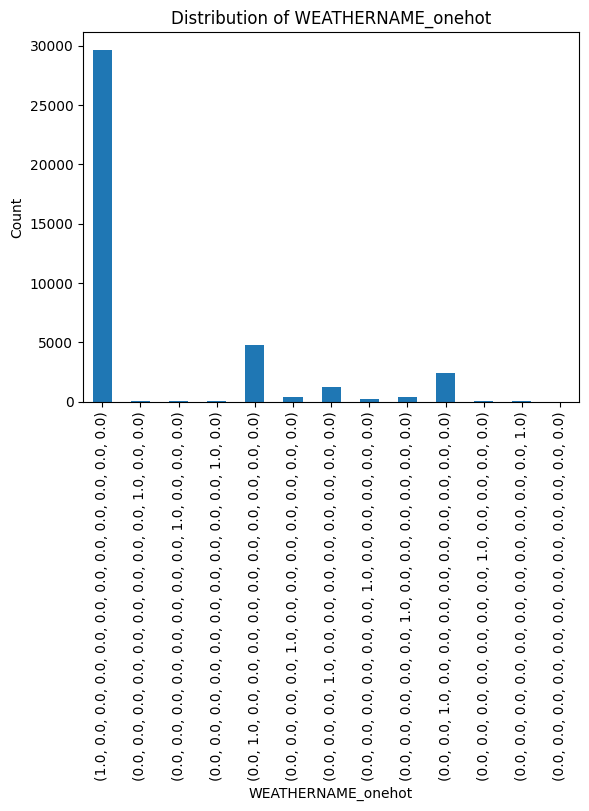

In [ ]:
# Example visualization for WEATHERNAME_onehot
weather_counts = df_with_features.groupBy("WEATHERNAME_onehot").count().toPandas()
weather_counts.plot(kind="bar", x="WEATHERNAME_onehot", y="count", legend=False)
plt.title("Distribution of WEATHERNAME_onehot")
plt.xlabel("WEATHERNAME_onehot")
plt.ylabel("Count")
plt.show()

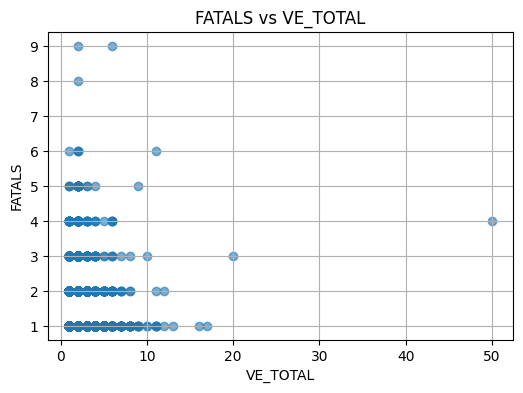

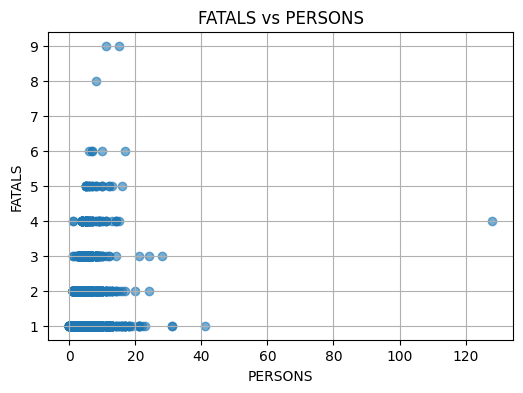

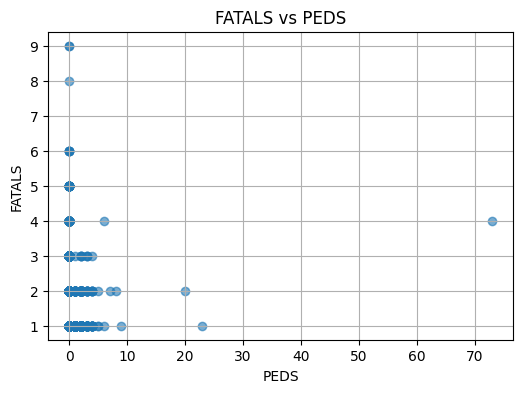

In [ ]:
# Scatter plots for FATALS vs other numeric variables
for col in ["VE_TOTAL", "PERSONS", "PEDS"]:
    plt.figure(figsize=(6, 4))
    plt.scatter(numeric_data[col], numeric_data["FATALS"], alpha=0.6)
    plt.title(f"FATALS vs {col}")
    plt.xlabel(col)
    plt.ylabel("FATALS")
    plt.grid(axis="both")
    plt.show()

#### Modeling

##### K-Means Clustering

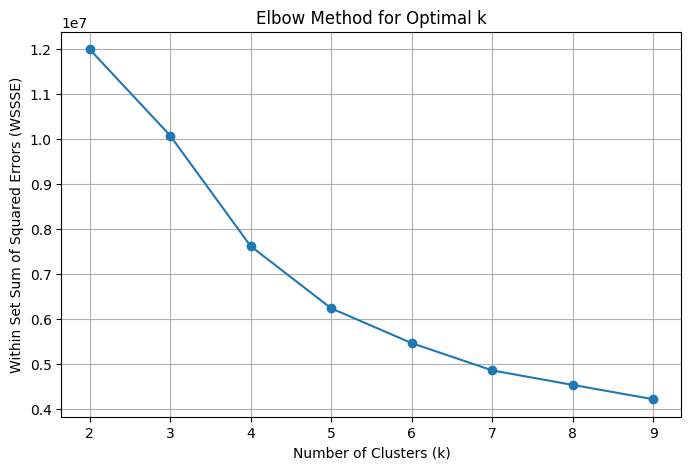

Silhouette Score: 0.3734035409682376


In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import numpy as np

# Determine optimal number of clusters (Elbow Method)
wssse_values = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(df_with_features)
    wssse_values.append(model.summary.trainingCost)

# Plot WSSSE for Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, wssse_values, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within Set Sum of Squared Errors (WSSSE)")
plt.grid()
plt.show()

# Train final K-Means model with chosen k
optimal_k = 3
kmeans = KMeans(featuresCol="features", k=optimal_k, seed=42)
kmeans_model = kmeans.fit(df_with_features)

# Evaluate using Silhouette Score
clustered_df = kmeans_model.transform(df_with_features)
evaluator = ClusteringEvaluator(featuresCol="features")
silhouette_score = evaluator.evaluate(clustered_df)
print(f"Silhouette Score: {silhouette_score}")

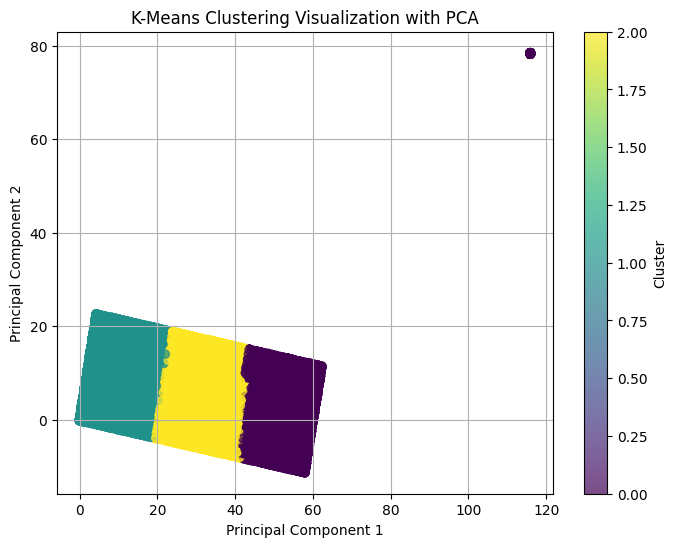

In [ ]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA to reduce dimensions
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_with_features)
pca_result = pca_model.transform(clustered_df)

# Ensure the `prediction` column exists
pca_result = pca_result.select("pca_features", "prediction")

# Convert to Pandas for visualization
pca_pd = pca_result.toPandas()

# Plot PCA-reduced clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pca_pd["pca_features"].apply(lambda x: x[0]),
    pca_pd["pca_features"].apply(lambda x: x[1]),
    c=pca_pd["prediction"], cmap="viridis", alpha=0.7
)
plt.title("K-Means Clustering Visualization with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Cluster")
plt.grid()
plt.show()

In [ ]:
clustered_df.printSchema()

root
 |-- FATALS: integer (nullable = true)
 |-- VE_TOTAL: integer (nullable = true)
 |-- PERSONS: integer (nullable = true)
 |-- PEDS: integer (nullable = true)
 |-- HARM_EVNAME_onehot: vector (nullable = true)
 |-- MAN_COLLNAME_onehot: vector (nullable = true)
 |-- WEATHERNAME_onehot: vector (nullable = true)
 |-- LGT_CONDNAME_onehot: vector (nullable = true)
 |-- FUNC_SYSNAME_onehot: vector (nullable = true)
 |-- REL_ROADNAME_onehot: vector (nullable = true)
 |-- TYP_INTNAME_onehot: vector (nullable = true)
 |-- WRK_ZONENAME_onehot: vector (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- MINUTE: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: integer (nullable = false)



In [ ]:
from pyspark.sql import functions as F

# Cluster profiling with available numerical features
cluster_profile = clustered_df.groupBy("prediction").agg(
    F.mean("FATALS").alias("Avg_Fatalities"),
    F.mean("VE_TOTAL").alias("Avg_Vehicles"),
    F.mean("PERSONS").alias("Avg_Persons"),
    F.mean("PEDS").alias("Avg_Pedestrians"),
    F.mean("MONTH").alias("Avg_Month"),
    F.mean("DAY").alias("Avg_Day"),
    F.mean("HOUR").alias("Avg_Hour"),
    F.count("*").alias("Cluster_Size")
)

# Show the profiling results
cluster_profile.show()

+----------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------+
|prediction|    Avg_Fatalities|      Avg_Vehicles|       Avg_Persons|    Avg_Pedestrians|         Avg_Month|           Avg_Day|          Avg_Hour|Cluster_Size|
+----------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------+
|         1| 1.089000075809264|1.5789553483435677|2.2205291486619667|0.23478129027367145|6.7268592221969525| 15.69084982184823|12.781214464407551|       13191|
|         2|1.0819251336898397|1.5879500891265597|2.1819607843137256|0.24520499108734403| 6.670231729055258|15.703529411764706|12.576114081996435|       14025|
|         0| 1.080071754729289|1.5786855838225702|2.1853392041748205|0.25220156555772993| 6.691943900848011|15.696428571428571|15.264187866927593|       12264|
+----------+------------------+---------

##### Linear Regression

In [ ]:
from pyspark.sql.functions import col

# Prepare data for regression
regression_data = df_with_features.select("features", col("FATALS").alias("label"))

# Split data into training and test sets
train_data, test_data = regression_data.randomSplit([0.8, 0.2], seed=42)

print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")

Training Data Count: 31716
Test Data Count: 7764


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
# Initialize Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="label")

# Train the model
lr_model = lr.fit(train_data)

# Print model coefficients and intercept
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

Coefficients: [-0.06476409637785764,0.07058866249271338,0.08532284164602243,0.49119854891756587,0.010977424492397157,0.11596606815321482,0.13613700490542646,0.14555863105751818,0.026043643566932666,0.13215080955395456,0.12077357482226873,0.09947653626097117,0.13485981990934365,0.13865912852052362,0.19333257261200668,0.12882088317564339,0.12591539029473728,0.11577575070719864,0.12440246804404186,0.14457868573193908,0.11228151001828622,0.025163477318906984,0.05069997255226621,0.13898353587004292,0.09878147741579064,0.13049957350313987,0.13252309027138634,0.29378161875789266,0.10823910584114214,0.2276409504214117,0.1199691515977153,0.20394934982575358,0.11446452388962396,0.1035206360386832,0.2690449850853716,0.15588475670686705,0.0976369970390929,0.11195142697114974,0.15615035666838123,0.1511493092164726,0.16986183637051655,0.2404068678750559,0.23669746501683378,0.38134362800330074,0.19025083134226664,0.19909262796139718,0.05428593018122915,0.08366807867028124,0.17656727476957623,0.160762

In [ ]:
training_summary = lr_model.summary
print(training_summary)

In [ ]:
print("Linear Regression Model Summary:")
print(f"Root Mean Squared Error (RMSE): {training_summary.rootMeanSquaredError}")
print(f"Mean Absolute Error (MAE): {training_summary.meanAbsoluteError}")
print(f"R2: {training_summary.r2}")
print(f"Explained Variance: {training_summary.explainedVariance}")
print(f"Mean Squared Error (MSE): {training_summary.meanSquaredError}")

Linear Regression Model Summary:
Root Mean Squared Error (RMSE): 0.3243811458572773
Mean Absolute Error (MAE): 0.14625085414117037
R2: 0.11570470586373804
Explained Variance: 0.013767811647824913
Mean Squared Error (MSE): 0.10522312778768021


In [ ]:
print("\nResiduals:")
training_summary.residuals.show()


Residuals:
+--------------------+
|           residuals|
+--------------------+
|-0.27388151585863185|
|-8.95522159136907...|
| -0.2029790829220246|
| -0.2861061711714874|
|-0.18649681151563513|
| -0.3234601839894389|
|-0.11712992621031804|
| -0.2050121640918996|
|-0.33573894939090354|
|-0.10327145953835148|
|-0.04831458874131078|
|-0.11552490038230179|
|-0.05145017051472145|
|-0.16782135245847707|
|-0.31844569395904476|
|  0.8311924154137647|
|-0.47886939699269426|
|  -0.175745748396003|
|-0.38563789921696845|
|-0.10470521850254344|
+--------------------+
only showing top 20 rows



In [ ]:
test_predictions = lr_model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
evaluator_mse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")

rmse_test = evaluator_rmse.evaluate(test_predictions)
mae_test = evaluator_mae.evaluate(test_predictions)
r2_test = evaluator_r2.evaluate(test_predictions)
mse_test = evaluator_mse.evaluate(test_predictions)

# Display the summary
print("Test Summary:")
print(f"Root Mean Squared Error (RMSE): {rmse_test}")
print(f"Mean Absolute Error (MAE): {mae_test}")
print(f"R2: {r2_test}")
print(f"Mean Squared Error (MSE): {mse_test}")

Test Summary:
Root Mean Squared Error (RMSE): 0.3354765271553769
Mean Absolute Error (MAE): 0.1492187318711884
R2: 0.11414239159324835
Mean Squared Error (MSE): 0.11254450027223233


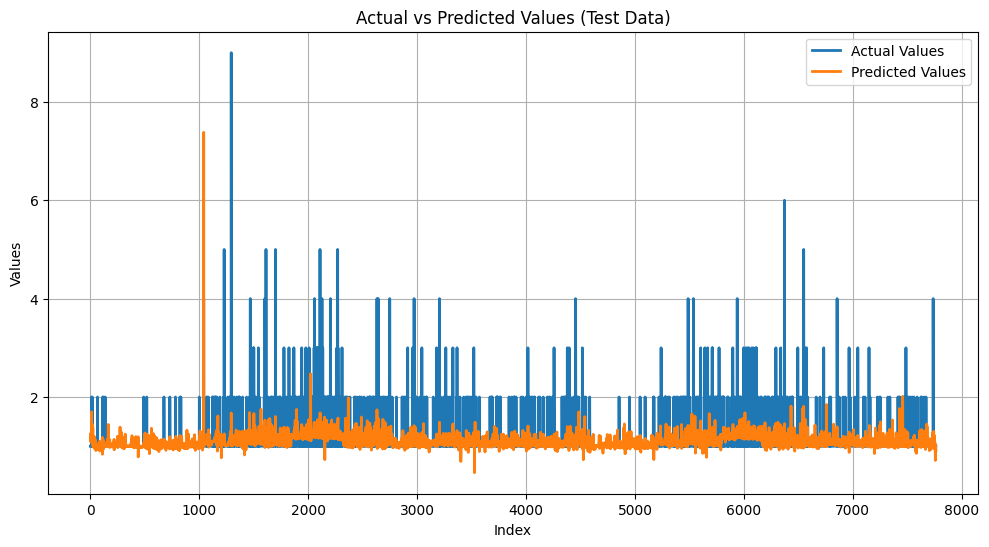

In [ ]:
from pyspark.sql.functions import expr
import matplotlib.pyplot as plt

# Extract actual and predicted values
actual_values_test = test_predictions.select("label").rdd.flatMap(lambda x: x).collect()
predicted_values_test = test_predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Create a line plot for actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(len(actual_values_test)), actual_values_test, label="Actual Values", linewidth=2)

# Plot predicted values
plt.plot(range(len(predicted_values_test)), predicted_values_test, label="Predicted Values", linewidth=2)

# Customize the plot
plt.title("Actual vs Predicted Values (Test Data)")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()


##### Decision Tree Regressor

Best Model Parameters: Max Depth = 5, Min Instances Per Node = 5


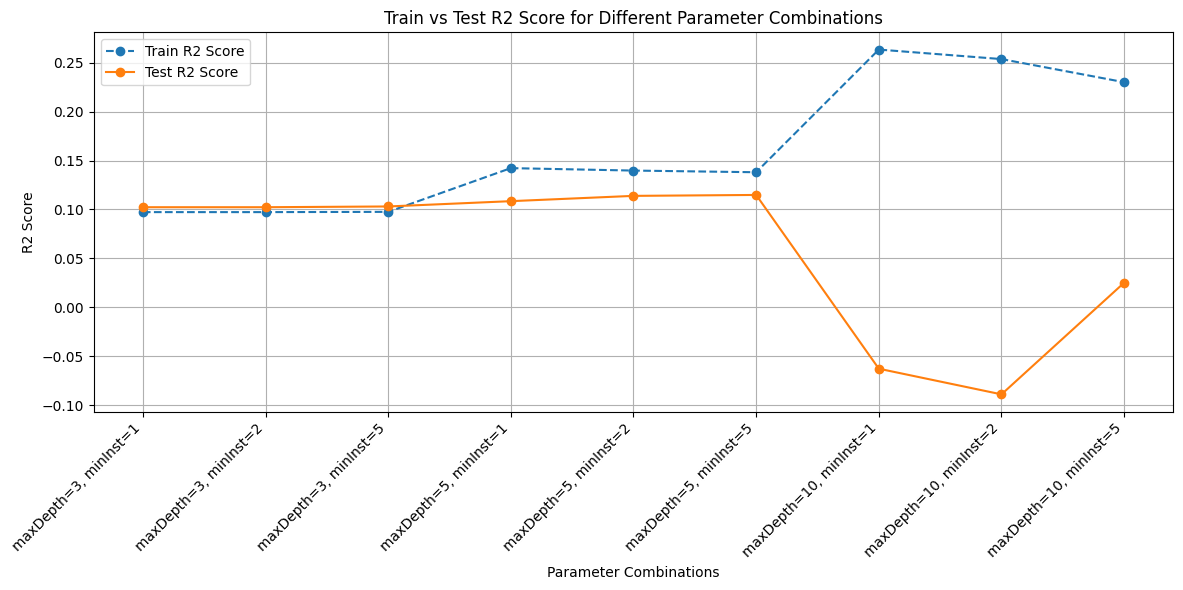

                                          Parameters  Train R2 Score  \
0  {DecisionTreeRegressor_e2db361e3a27__maxDepth:...        0.097289   
1  {DecisionTreeRegressor_e2db361e3a27__maxDepth:...        0.097289   
2  {DecisionTreeRegressor_e2db361e3a27__maxDepth:...        0.097556   
3  {DecisionTreeRegressor_e2db361e3a27__maxDepth:...        0.142220   
4  {DecisionTreeRegressor_e2db361e3a27__maxDepth:...        0.139726   
5  {DecisionTreeRegressor_e2db361e3a27__maxDepth:...        0.138023   
6  {DecisionTreeRegressor_e2db361e3a27__maxDepth:...        0.263324   
7  {DecisionTreeRegressor_e2db361e3a27__maxDepth:...        0.253614   
8  {DecisionTreeRegressor_e2db361e3a27__maxDepth:...        0.230005   

   Test R2 Score  
0       0.102287  
1       0.102287  
2       0.103058  
3       0.108475  
4       0.113885  
5       0.114832  
6      -0.062665  
7      -0.088869  
8       0.025171  


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label")

# Create parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 10]) \
    .addGrid(dt.minInstancesPerNode, [1, 2, 5]) \
    .build()

# Set up cross-validation
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
# Set up cross-validation with subModels enabled
cv = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_rmse,
                    numFolds=5,
                    collectSubModels=True)  # Enable collection of subModels

# Train the model using cross-validation
cv_model = cv.fit(train_data)

# Get the best model
best_model = cv_model.bestModel

# Print best parameters
print(f"Best Model Parameters: Max Depth = {best_model.getOrDefault('maxDepth')}, Min Instances Per Node = {best_model.getOrDefault('minInstancesPerNode')}")

# Evaluate the best model on training data
train_predictions_dt = best_model.transform(train_data)
test_predictions_dt = best_model.transform(test_data)

# Initialize evaluators for other metrics
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")

# Training metrics
train_rmse = evaluator_rmse.evaluate(train_predictions_dt)
train_r2 = evaluator_r2.evaluate(train_predictions_dt)
train_mae = evaluator_mae.evaluate(train_predictions_dt)
train_mape = train_predictions_dt.selectExpr("avg(abs(label - prediction) / label) * 100 as mape").collect()[0][0]

# Test metrics
test_rmse = evaluator_rmse.evaluate(test_predictions_dt)
test_r2 = evaluator_r2.evaluate(test_predictions_dt)
test_mae = evaluator_mae.evaluate(test_predictions_dt)
test_mape = test_predictions_dt.selectExpr("avg(abs(label - prediction) / label) * 100 as mape").collect()[0][0]

# Store parameter combinations and RMSE scores for plotting
params = []
train_scores = []
test_scores = []

# Iterate through each parameter combination
for model, param in zip(cv_model.subModels[0], paramGrid):
    # Store the current parameters
    params.append(param)

    # Evaluate on training data
    train_r = evaluator_r2.evaluate(model.transform(train_data))
    train_scores.append(train_r)

    # Evaluate on test data
    test_r = evaluator_r2.evaluate(model.transform(test_data))
    test_scores.append(test_r)

# Combine results into a Pandas DataFrame
results_df = pd.DataFrame({
    "Parameters": params,
    "Train R2 Score": train_scores,
    "Test R2 Score": test_scores
})

# Extract and format parameter combinations for better readability
param_combinations = [
    f"maxDepth={p[dt.maxDepth]}, minInst={p[dt.minInstancesPerNode]}" for p in params
]

# Plot Train and Test RMSE
plt.figure(figsize=(12, 6))
plt.plot(param_combinations, train_scores, label="Train R2 Score", marker='o', linestyle='--')
plt.plot(param_combinations, test_scores, label="Test R2 Score", marker='o', linestyle='-')

# Formatting the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel("Parameter Combinations")
plt.ylabel("R2 Score")
plt.title("Train vs Test R2 Score for Different Parameter Combinations")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Display results in table form
print(results_df)

In [ ]:

# Print Train and Test Summary
print("\nBest Model Training Performance:")
print(f"RMSE: {train_rmse}")
print(f"R2: {train_r2}")
print(f"MAE: {train_mae}")
print(f"MAPE: {train_mape:.2f}%")

print("\nBest Model Test Performance:")
print(f"RMSE: {test_rmse}")
print(f"R2: {test_r2}")
print(f"MAE: {test_mae}")
print(f"MAPE: {test_mape:.2f}%")


Best Model Training Performance:
RMSE: 0.31971975328661567
R2: 0.1409369391772073
MAE: 0.1332046432795662
MAPE: 9.52%

Best Model Test Performance:
RMSE: 0.33394334329048103
R2: 0.12222092419544839
MAE: 0.13606591400353588
MAPE: 9.68%


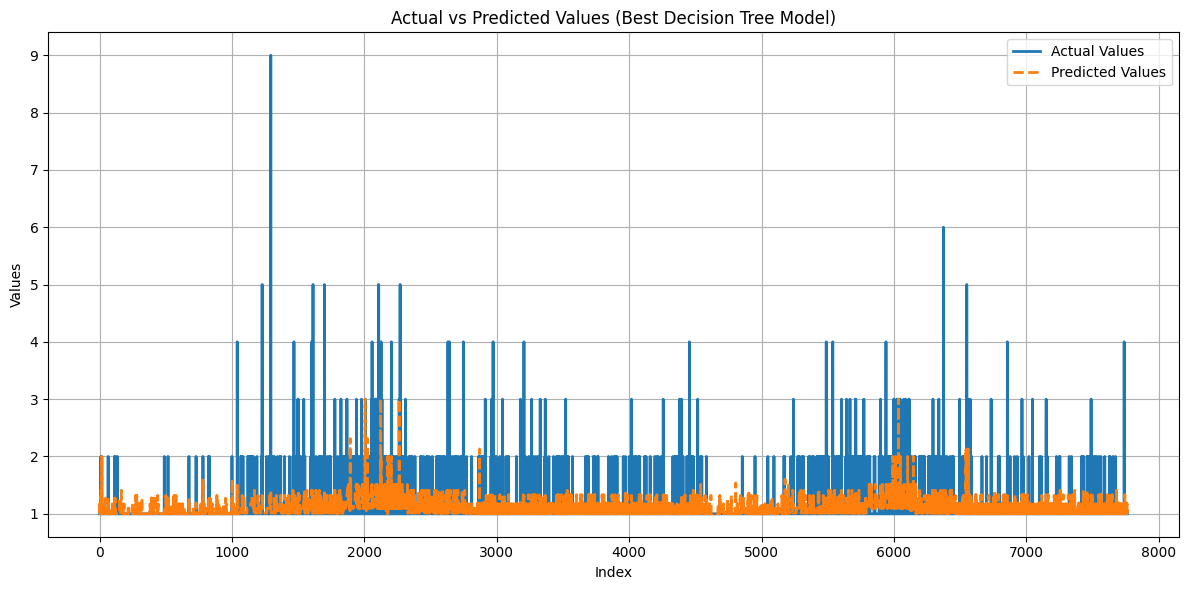

In [ ]:
# Extract actual and predicted values for plotting
actual_values = test_predictions_dt.select("label").rdd.flatMap(lambda x: x).collect()
predicted_values = test_predictions_dt.select("prediction").rdd.flatMap(lambda x: x).collect()

# Create a plot for actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(len(actual_values)), actual_values, label="Actual Values", linewidth=2)

# Plot predicted values
plt.plot(range(len(predicted_values)), predicted_values, label="Predicted Values", linewidth=2, linestyle='--')

# Customize the plot
plt.title("Actual vs Predicted Values (Best Decision Tree Model)")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### Random Forest Regressor

Best Parameters: numTrees = 100, maxDepth = 10


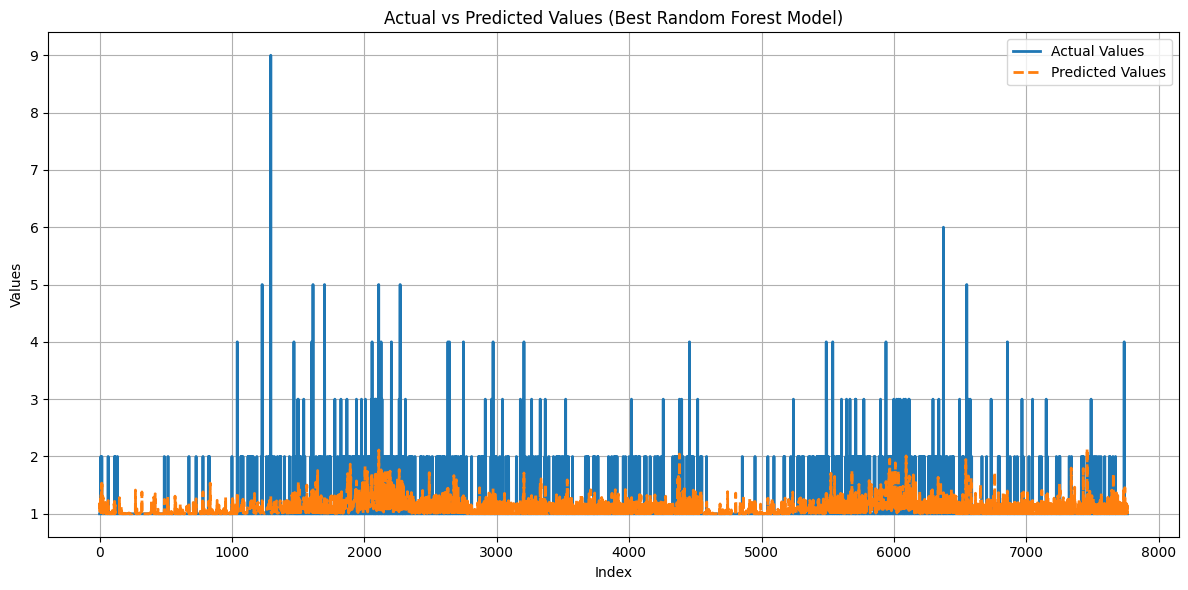

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import expr
import matplotlib.pyplot as plt

# Initialize Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="label", seed=42)

# Define a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [3, 5, 10]) \
    .build()

# Define evaluators
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")

# Set up cross-validation
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_rmse,
                    numFolds=5)

# Train the model using cross-validation
cv_model = cv.fit(train_data)

# Get the best model
best_rf_model = cv_model.bestModel

# Print best parameters
print(f"Best Parameters: numTrees = {best_rf_model.getOrDefault('numTrees')}, maxDepth = {best_rf_model.getOrDefault('maxDepth')}")

# Evaluate the best model on training data
train_predictions = best_rf_model.transform(train_data)
test_predictions = best_rf_model.transform(test_data)

# Rename prediction column to 'prediction_rf'
train_predictions_rf = train_predictions.withColumnRenamed("prediction", "prediction_rf")
test_predictions_rf = test_predictions.withColumnRenamed("prediction", "prediction_rf")

# Calculate evaluation metrics for training data
train_rmse = evaluator_rmse.evaluate(train_predictions)
train_r2 = evaluator_r2.evaluate(train_predictions)
train_mae = evaluator_mae.evaluate(train_predictions)
train_mape = train_predictions.selectExpr(
    "avg(abs(label - prediction) / label) * 100 as mape"
).collect()[0][0]

# Calculate evaluation metrics for test data
test_rmse = evaluator_rmse.evaluate(test_predictions)
test_r2 = evaluator_r2.evaluate(test_predictions)
test_mae = evaluator_mae.evaluate(test_predictions)
test_mape = test_predictions.selectExpr(
    "avg(abs(label - prediction) / label) * 100 as mape"
).collect()[0][0]

# Plot actual vs predicted for test data
actual_values = test_predictions_rf.select("label").rdd.flatMap(lambda x: x).collect()
predicted_values = test_predictions_rf.select("prediction_rf").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_values)), actual_values, label="Actual Values", linewidth=2)
plt.plot(range(len(predicted_values)), predicted_values, label="Predicted Values", linewidth=2, linestyle='--')
plt.title("Actual vs Predicted Values (Best Random Forest Model)")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Print evaluation results
print("\nRandom Forest Training Performance:")
print(f"RMSE: {train_rmse}")
print(f"R2: {train_r2}")
print(f"MAE: {train_mae}")
print(f"MAPE: {train_mape:.2f}%")

print("\nRandom Forest Test Performance:")
print(f"RMSE: {test_rmse}")
print(f"R2: {test_r2}")
print(f"MAE: {test_mae}")
print(f"MAPE: {test_mape:.2f}%")


Random Forest Training Performance:
RMSE: 0.2807981790060998
R2: 0.33736452786078974
MAE: 0.12027979540692346
MAPE: 8.61%

Random Forest Test Performance:
RMSE: 0.33187999776031796
R2: 0.13303453213443994
MAE: 0.1352268013631125
MAPE: 9.59%


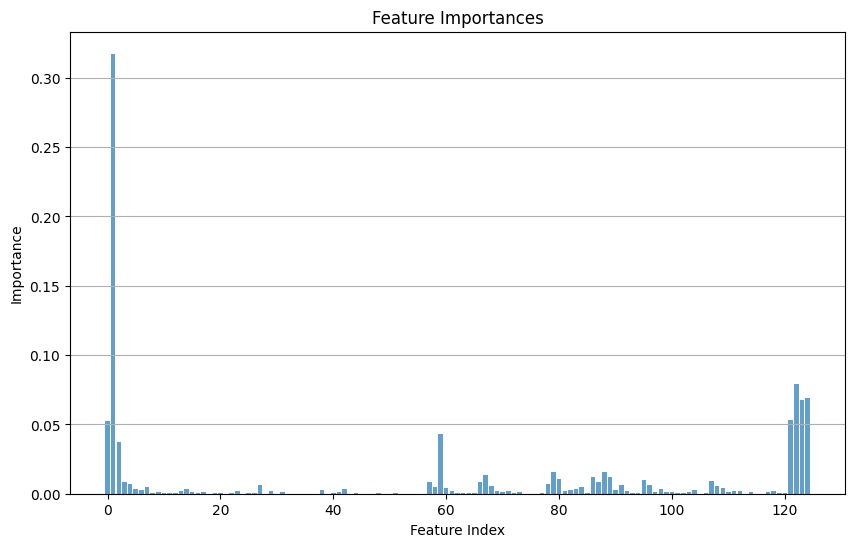

In [ ]:
# Plot feature importances
feature_importances = best_rf_model.featureImportances.toArray()

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, alpha=0.7)
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.grid(axis="y")
plt.show()


In [ ]:
try:
    # If using VectorAssembler, retrieve feature names
    feature_names = assembler.getInputCols()
except NameError:
    # If VectorAssembler is not available, create placeholder feature names
    num_features = len(best_rf_model.featureImportances.toArray())  # Total number of features
    feature_names = [f"feature_{i+1}" for i in range(num_features)]

# Extract feature importances from the trained model
feature_importances = best_rf_model.featureImportances.toArray()

# Combine feature names with their importance
features_with_importance = list(zip(feature_names, feature_importances))

# Sort features by importance in descending order
sorted_features = sorted(features_with_importance, key=lambda x: x[1], reverse=True)

# Get the top 10 features
top_10_features = sorted_features[:10]

# Print the top 10 features
print("Top 10 Features by Importance:")
for feature, importance in top_10_features:
    print(f"{feature}: {importance:.4f}")

Top 10 Features by Importance:
PERSONS: 0.3174
VE_TOTAL: 0.0525
PEDS: 0.0376
HARM_EVNAME_onehot: 0.0082
MAN_COLLNAME_onehot: 0.0073
FUNC_SYSNAME_onehot: 0.0047
MINUTE: 0.0033
WEATHERNAME_onehot: 0.0031
LGT_CONDNAME_onehot: 0.0026
HOUR: 0.0022


### **Classification**

##### Data Preparation

In [ ]:
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Derive Severity_Level from FATALS
df_for_classification = df_with_features.withColumn(
    "Severity_Level",
    when(df_with_features["FATALS"] <= 1, "Low")
    .when((df_with_features["FATALS"] > 1) & (df_with_features["FATALS"] <= 3), "Medium")
    .otherwise("High")
)

# Drop FATALS as it's derived and won't be used further
df_for_classification = df_for_classification.drop("FATALS")

# Encode the target column (Severity_Level) as numeric
indexer = StringIndexer(inputCol="Severity_Level", outputCol="label")
df_for_classification = indexer.fit(df_for_classification).transform(df_for_classification)

# Assemble all feature columns into a single vector column
feature_columns = [col for col in df_for_classification.columns if col not in ["Severity_Level", "label", "features"]]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_unscaled")
df_for_classification = assembler.transform(df_for_classification)

# Drop the existing 'features' column if it exists
if "features" in df_for_classification.columns:
    df_for_classification = df_for_classification.drop("features")

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler(inputCol="features_unscaled", outputCol="features")
df_for_classification = scaler.fit(df_for_classification).transform(df_for_classification)

# Split the data into training and test sets
train_classification_data, test_classification_data = df_for_classification.randomSplit([0.8, 0.2], seed=42)

# Show class distribution in training data
train_class_distribution = train_classification_data.groupBy("Severity_Level").count().toPandas()
print("Training Data Class Distribution:")
print(train_class_distribution)

# Show class distribution in test data
test_class_distribution = test_classification_data.groupBy("Severity_Level").count().toPandas()
print("\nTest Data Class Distribution:")
print(test_class_distribution)

Training Data Class Distribution:
  Severity_Level  count
0           High    105
1            Low  29543
2         Medium   2068

Test Data Class Distribution:
  Severity_Level  count
0           High     19
1            Low   7247
2         Medium    498


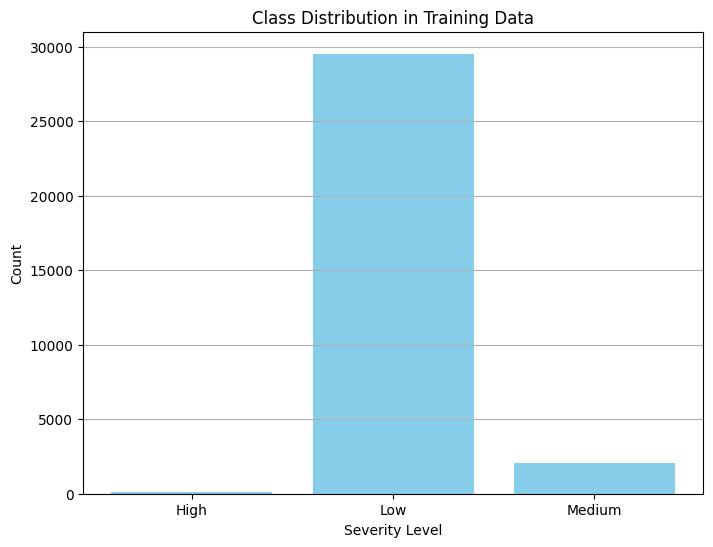

In [ ]:
import matplotlib.pyplot as plt

# Plot the class distribution in training data
train_class_distribution = train_classification_data.groupBy("Severity_Level").count().toPandas()
plt.figure(figsize=(8, 6))
plt.bar(train_class_distribution["Severity_Level"], train_class_distribution["count"], color='skyblue')
plt.title("Class Distribution in Training Data")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

##### Multinomial Logistic Regression

Multinomial Logistic Regression Metrics:
Accuracy: 0.93
F1 Score: 0.90
Precision: 0.89
Recall: 0.93


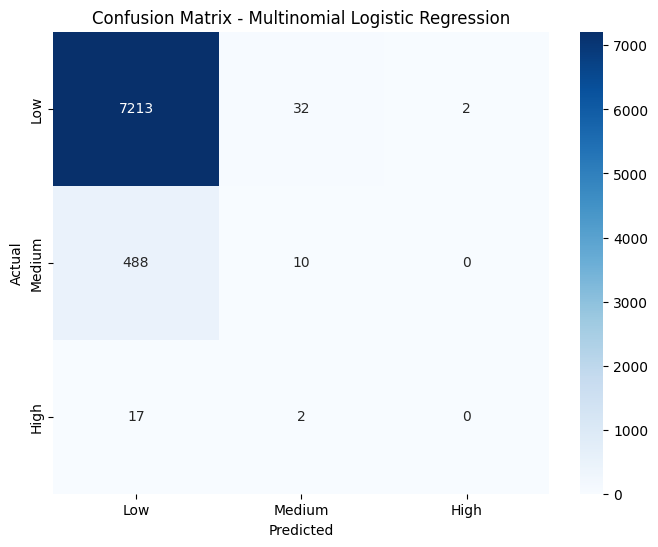


Classification Report:
              precision    recall  f1-score   support

         Low       0.93      1.00      0.96      7247
      Medium       0.23      0.02      0.04       498
        High       0.00      0.00      0.00        19

    accuracy                           0.93      7764
   macro avg       0.39      0.34      0.33      7764
weighted avg       0.89      0.93      0.90      7764



In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np

# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20, family="multinomial")

# Train the model
lr_model = lr.fit(train_classification_data)

# Evaluate on test data
predictions_lr = lr_model.transform(test_classification_data)

# Evaluate classification metrics
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

accuracy = evaluator_accuracy.evaluate(predictions_lr)
f1_score = evaluator_f1.evaluate(predictions_lr)
precision = evaluator_precision.evaluate(predictions_lr)
recall = evaluator_recall.evaluate(predictions_lr)

# Print metrics
print("Multinomial Logistic Regression Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Confusion Matrix
y_true = predictions_lr.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = predictions_lr.select("prediction").rdd.flatMap(lambda x: x).collect()
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix - Multinomial Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Low", "Medium", "High"]))


##### Decision Tree Classifier


Decision Tree Classifier Metrics:
Accuracy: 0.93
F1 Score: 0.90
Precision: 0.90
Recall: 0.93


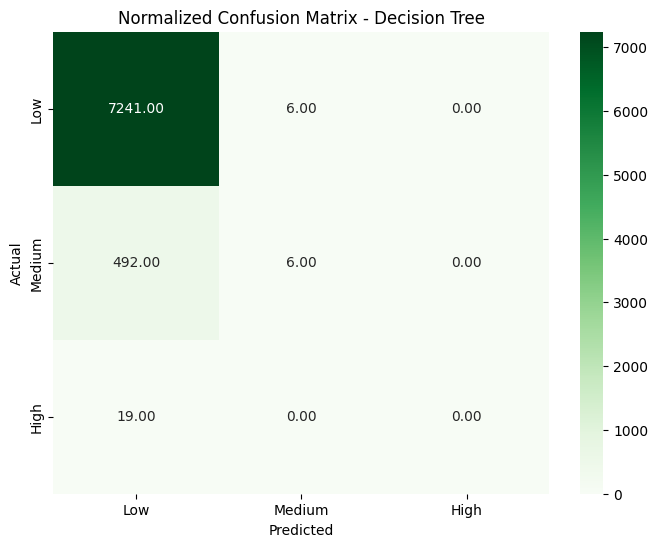


Classification Report - Decision Tree:
              precision    recall  f1-score   support

         Low       0.93      1.00      0.97      7247
      Medium       0.50      0.01      0.02       498
        High       0.00      0.00      0.00        19

    accuracy                           0.93      7764
   macro avg       0.48      0.34      0.33      7764
weighted avg       0.90      0.93      0.90      7764



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Create parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.minInstancesPerNode, [1, 2, 5]) \
    .build()

# Define evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# Set up cross-validation
cv = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_accuracy,
                    numFolds=5)

# Train the model using cross-validation
cv_model = cv.fit(train_classification_data)

# Get the best model
best_dt_model = cv_model.bestModel

# Evaluate on test data
predictions_dt = best_dt_model.transform(test_classification_data)

# Evaluate classification metrics
accuracy_dt = evaluator_accuracy.evaluate(predictions_dt)
f1_score_dt = evaluator_f1.evaluate(predictions_dt)
precision_dt = evaluator_precision.evaluate(predictions_dt)
recall_dt = evaluator_recall.evaluate(predictions_dt)

# Print metrics
print("\nDecision Tree Classifier Metrics:")
print(f"Accuracy: {accuracy_dt:.2f}")
print(f"F1 Score: {f1_score_dt:.2f}")
print(f"Precision: {precision_dt:.2f}")
print(f"Recall: {recall_dt:.2f}")

# Confusion Matrix
y_true_dt = predictions_dt.select("label").rdd.flatMap(lambda x: x).collect()
y_pred_dt = predictions_dt.select("prediction").rdd.flatMap(lambda x: x).collect()
conf_matrix_dt = confusion_matrix(y_true_dt, y_pred_dt)

# Normalized Confusion Matrix
normalized_conf_matrix = conf_matrix_dt

# Plot Normalized Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_conf_matrix, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.title("Normalized Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report with zero_division handling
print("\nClassification Report - Decision Tree:")
print(classification_report(y_true_dt, y_pred_dt, target_names=["Low", "Medium", "High"]))

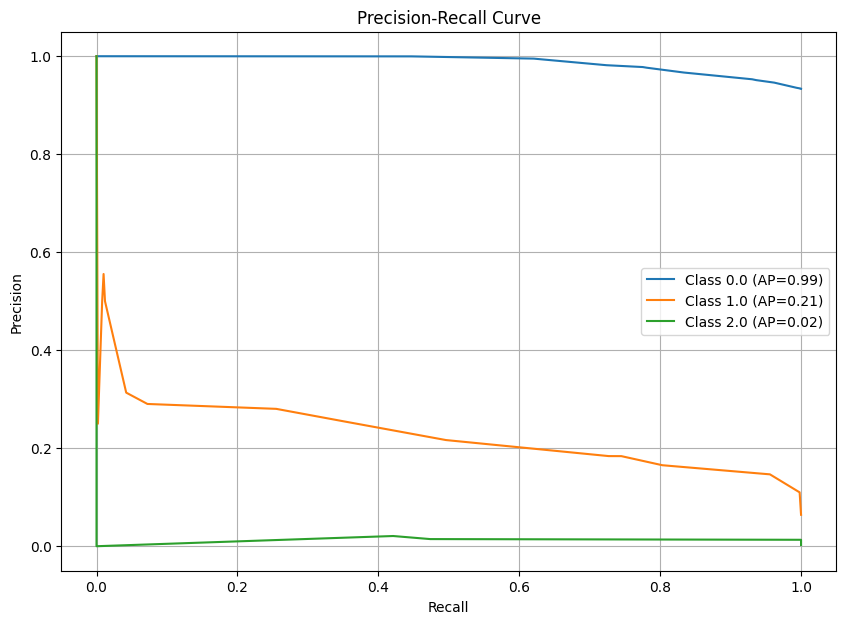

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Extract probabilities and labels
predictions_pd = predictions_dt.select("label", "probability").toPandas()

# Convert the probability vector to individual columns
probabilities = np.array(predictions_pd["probability"].tolist())  # Convert to NumPy array
y_true = predictions_pd["label"].values

# Binarize labels for multi-class precision-recall
classes = sorted(predictions_pd["label"].unique())  # List of class labels
y_true_binarized = label_binarize(y_true, classes=classes)

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(10, 7))
for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], probabilities[:, i])
    average_precision = average_precision_score(y_true_binarized[:, i], probabilities[:, i])
    plt.plot(recall, precision, label=f"Class {class_label} (AP={average_precision:.2f})")

# Configure plot
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid()
plt.show()

##### Random Forest Classifier


Random Forest Classifier Metrics:
Accuracy: 0.93
F1 Score: 0.90
Precision: 0.87
Recall: 0.93


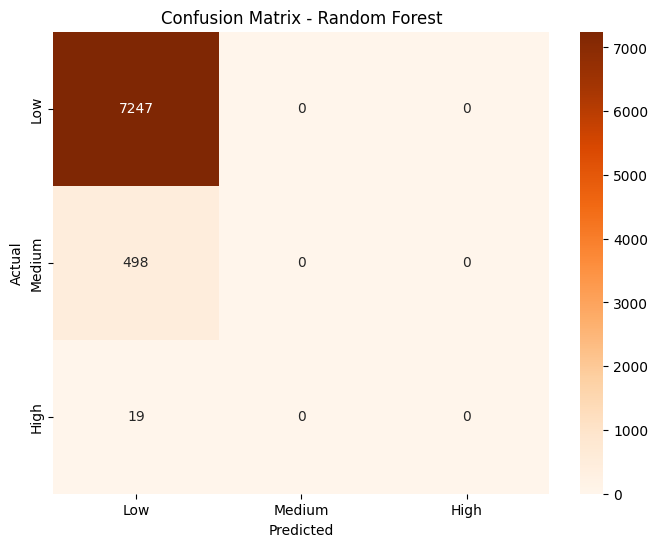


Classification Report - Random Forest:
              precision    recall  f1-score   support

         Low       0.93      1.00      0.97      7247
      Medium       0.00      0.00      0.00       498
        High       0.00      0.00      0.00        19

    accuracy                           0.93      7764
   macro avg       0.31      0.33      0.32      7764
weighted avg       0.87      0.93      0.90      7764



In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

# Create parameter grid for hyperparameter tuning
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Define evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# Set up cross-validation
cv_rf = CrossValidator(estimator=rf,
                       estimatorParamMaps=paramGrid_rf,
                       evaluator=evaluator_accuracy,
                       numFolds=5)

# Train the model using cross-validation
cv_rf_model = cv_rf.fit(train_classification_data)

# Get the best model
best_rf_model = cv_rf_model.bestModel

# Evaluate on test data
predictions_rf = best_rf_model.transform(test_classification_data)

# Evaluate classification metrics
accuracy_rf = evaluator_accuracy.evaluate(predictions_rf)
f1_score_rf = evaluator_f1.evaluate(predictions_rf)
precision_rf = evaluator_precision.evaluate(predictions_rf)
recall_rf = evaluator_recall.evaluate(predictions_rf)

# Print metrics
print("\nRandom Forest Classifier Metrics:")
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"F1 Score: {f1_score_rf:.2f}")
print(f"Precision: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")

# Confusion Matrix
y_true_rf = predictions_rf.select("label").rdd.flatMap(lambda x: x).collect()
y_pred_rf = predictions_rf.select("prediction").rdd.flatMap(lambda x: x).collect()
conf_matrix_rf = confusion_matrix(y_true_rf, y_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report - Random Forest:")
print(classification_report(y_true_rf, y_pred_rf, target_names=["Low", "Medium", "High"], zero_division=0))

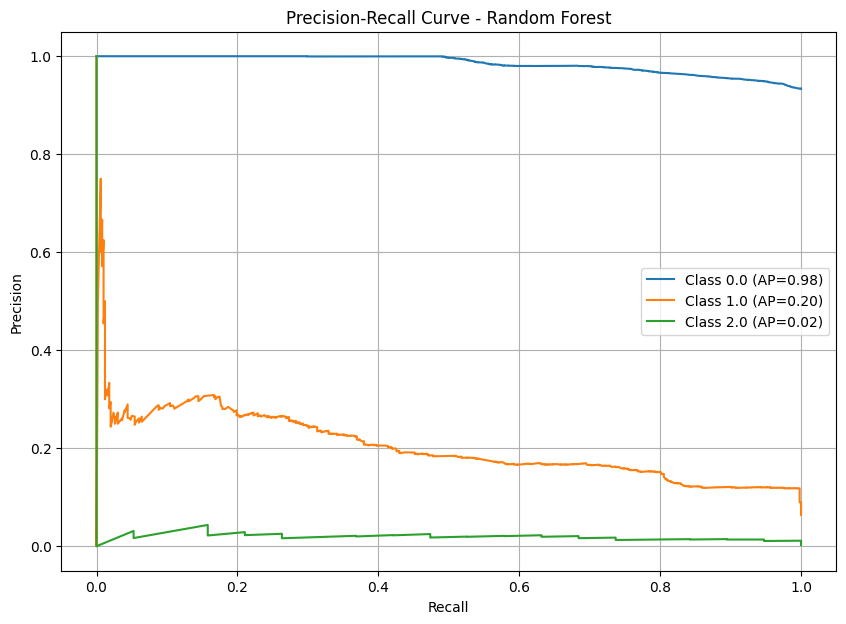

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

# Convert probabilities from DenseVector to array
probability_to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
predictions_rf = predictions_rf.withColumn("probability_array", probability_to_array(predictions_rf["probability"]))

# Convert to Pandas
predictions_pd_rf = predictions_rf.select("label", "probability_array").toPandas()

# Extract probabilities and labels
probabilities_rf = np.array(predictions_pd_rf["probability_array"].tolist())
y_true_rf = predictions_pd_rf["label"].values

# Ensure consistent class labels
classes_rf = sorted(predictions_rf.select("label").distinct().rdd.flatMap(lambda x: x).collect())
y_true_binarized_rf = label_binarize(y_true_rf, classes=classes_rf)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
for i, class_label in enumerate(classes_rf):
    precision, recall, _ = precision_recall_curve(y_true_binarized_rf[:, i], probabilities_rf[:, i])
    average_precision = average_precision_score(y_true_binarized_rf[:, i], probabilities_rf[:, i])
    plt.plot(recall, precision, label=f"Class {class_label} (AP={average_precision:.2f})")

plt.title("Precision-Recall Curve - Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid()
plt.show()

In [ ]:
feature_names = assembler.getInputCols()

# Extract feature importances
feature_importances_rf = best_rf_model.featureImportances.toArray()

# Combine feature names with their importance values
features_with_importance_rf = list(zip(feature_names, feature_importances_rf))

# Sort features by importance in descending order
sorted_features_rf = sorted(features_with_importance_rf, key=lambda x: x[1], reverse=True)

# Get the top 10 features
top_10_features_rf = sorted_features_rf[:10]

# Print the top 10 features
print("Top 10 Features by Importance (Random Forest):")
for feature, importance in top_10_features_rf:
    print(f"{feature}: {importance:.4f}")

Top 10 Features by Importance (Random Forest):
PERSONS: 0.2739
PEDS: 0.1706
HARM_EVNAME_onehot: 0.0633
MAN_COLLNAME_onehot: 0.0486
VE_TOTAL: 0.0467
REL_ROADNAME_onehot: 0.0096
WEATHERNAME_onehot: 0.0031
MONTH: 0.0029
WRK_ZONENAME_onehot: 0.0022
LGT_CONDNAME_onehot: 0.0004
